In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Alerts data analysis

In [2]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/content/alerts_data.csv', index_col=False)

<ipython-input-3-3b425d876bd6>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/alerts_data.csv', index_col=False)


In [4]:
display(df.head(5))

,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,test_id,test_status,test_series_signature_id,test_series_signature_framework_id,test_series_signature_signature_hash,test_series_signature_machine_platform,test_series_signature_test,test_series_signature_suite,test_series_signature_lower_is_better,test_series_signature_has_subtests,test_series_signature_option_collection_hash,test_series_signature_tags,test_series_signature_extra_options,test_series_signature_measurement_unit,test_series_signature_suite_public_name,test_series_signature_test_public_name,test_prev_taskcluster_metadata_task_id,test_prev_taskcluster_metadata_retry_id,test_taskcluster_metadata_task_id,test_taskcluster_metadata_retry_id,test_profile_url,test_prev_profile_url,test_is_regression,test_prev_value,test_new_value,test_t_value,test_amount_abs,test_amount_pct,test_summary_id,test_related_summary_id,test_manually_created,test_classifier,test_starred,test_classifier_email,test_backfill_record_context,test_backfill_record_status,test_backfill_record_total_actions_triggered,test_backfill_record_total_backfills_failed,test_backfill_record_total_backfills_successful,test_backfill_record_total_backfills_in_progress,test_noise_profile,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags
0,139,1423417,1423368,2024-05-08T17:54:23.264764,NaN,2024-05-13T17:54:23.264764,autoland,6,496,0,4662919,6,2886a3d67e6faeb4aa8d2d13860caae4a5ab1a4d,windows11-32-2009-qr,PerfStripCharsCRLF,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,QP7M4A4lQ1y93AQ514z7LQ,0.0,ILQOT39SQomPqLe2F5StxQ,0.0,NaN,NaN,False,333164.25,223024.17,15.04,-110140.08,33.06,139,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OUTLIERS,NaN,0,NaN,2024-05-15T17:54:23.264764,NaN,1,NaN,ed7b6f65910afcd687ef5aaa25605666805796bb,1715173753,2dc2a910325211c4136365c9647e990a7c7dd22e,NaN,NaN,NaN
1,138,1423277,1423269,2024-05-08T17:24:58.063351,NaN,2024-05-13T17:24:58.063351,autoland,6,495,0,3482492,6,3f826ce9164041044ad62bd80940c584561f1a19,macosx1015-64-qr,PerfUTF8toUTF16KOThousand,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,DxpIrvXPSFKeXX8cvej11g,0.0,ConJc8EPTqmV-Kg92P3Otg,0.0,NaN,NaN,True,176813.12,212071.75,7.91,35258.62,19.94,138,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SKEWED,NaN,0,NaN,2024-05-15T17:24:58.063351,NaN,1,NaN,a5478f44911c8f8908f09e2fbc4d728c0d170497,1715148543,a0b3e2669a2dc49c467521cb9b7966ca05e3dbc3,NaN,NaN,NaN
2,137,1423124,1423077,2024-05-08T16:31:27.262251,NaN,2024-05-13T16:31:27.262251,autoland,6,493,0,3482392,6,77060156e1ae922a978c99ce35068106eb40749e,macosx1015-64-qr,PerfIsUTF8Hundred,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,e7Bev2E0S4SHmsXqEeid0A,0.0,JA8lSVK3RfWm_wia5nizNA,0.0,NaN,NaN,True,2821.71,3527.08,9.52,705.38,25.00,137,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OUTLIERS,NaN,0,NaN,2024-05-15T16:31:27.262251,NaN,1,NaN,149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a,1715120098,a2d3990d919176afe79ac26a0f781f1721c823e1,NaN,NaN,NaN
3,137,1423124,1423077,2024-05-08T16:31:27.262251,NaN,2024-05-13T16:31:27.262251,autoland,6,494,0,4662915,6,2606d85e165765a20f96a4e2f1d8b2990a4c721a,windows11-32-2009-qr,PerfStripWhitespace,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,UpAqMUYBTtSnbXnhlOD-xw,0.0,PTJKykhaSO-Vu8mmyTMyrg,0.0,NaN,NaN,False,69291.08,52940.00,7.66,-16351.08,23.60,137,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SKEWED,NaN,0,NaN,2024-05-15T16:31:27.262251,NaN,1,NaN,149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a,1715120098,a2d3990d919176afe79ac26a0f781f1721c823e1,NaN,NaN,NaN
4,136,1421812,1421623,2024-05-08T16:20:10.262939,NaN,2024-05-13T16:20:10.262939,autoland,13,492,

In [5]:
print("number of rows in the df")
print(df.shape[0])
print("number of rows where entries associated with test_series_signature_framework_id and alert_framework are identical")
print(len(df[df['alert_framework'] == df['test_series_signature_framework_id']]))
df.drop(columns=['test_series_signature_framework_id'], inplace=True)

number of rows in the df
18990
number of rows where entries associated with test_series_signature_framework_id and alert_framework are identical
18990


The conclusion is to drop column ```test_series_signature_framework_id``` as its values are identical to the ones of ```alert_framework```

In [6]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')

One of our goals is to find false positives meaning alerts that were triggered that are not improvement alerts but they're not regression alerts either. The following statuses are the ones that can be associated with a given alert :

- **untriaged** : these are the alerts that were not looked at by the performance team, so they are not classified, therefore it is impossible to detect their nature (false positives or not)
- **downstream** : Downstream alerts, as mentioned in the provided answer to the following question : "How can duplicate alerts can be identified?" in [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation, refer to alerts that are related to or affected by a particular original alert. Here's a simpler explanation:
Imagine you have an alert triggered by a specific issue, say a bug in a software component. This alert is the "original" alert. Now, downstream alerts are additional alerts that stem from or are related to this original alert.So, downstream alerts help to provide a more comprehensive view of the problem by capturing related issues or consequences of the original alert. It would make sense then to count them in as false positives as they are related to one change that propagates to different systems.
- **reassigned** : using common sense, these are alerts that were looked at, verdict was made about them, and then were decided to be looked at again, meaning they're still under investigation. Therefore they cannot be counted.
- **invalid** : looking at the answer for the question 'Do we care about all alerts/tests?' in [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation, the invalid alerts seem to be due to noise, making them false positives
- **improvement** : these are labeled improvements so they will be excluded from the count
- **investigating** : these ones trivially are alerts still under investigation, therefore they will not be taken into consideration
- **wontfix** : Looking at [this](https://bugzilla.mozilla.org/show_bug.cgi?id=1886674) and [this](https://bugzilla.mozilla.org/show_bug.cgi?id=1886163) bugs, 'wontfix' seems to represent false positives that do report alerts that shouldn't be triggered or were triggered for the wrong reasons
- **fixed** : this one trivially means that the issue triggered through the alert is fixed. Logically speaking, an improvement in performance does not lead to a fix nor a false positive alert does so. The only possibility is that this is a fixed regression, therefore this one will be considered a false positive
- **backedout** : As far as understood from [this](https://wiki.mozilla.org/Performance/Tools/FAQ#What_is_a_backout.3F) documentation (answering the What is a backout? question), it seems that 'backedout' implies that a given alert ended up with rollbacking the changes, which logically means that the push caused a regression that lead to the rollback. Therefore, this one will be considered as a true positive regression

In summary, untriaged, reassigned, investigating, and improvement alerts are not considered into determining false positive regressions. The alerts associated with downstream, invalid, wontfix, fixed, and backedout statuses are considered for the investigation, where the first three representing the false positives.

In [7]:
# the mapping was concluded by comparing data from the dataset with data on Perfherder
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
# the framwork mapping was taken from the following API endpiint's response : https://treeherder.mozilla.org/docs/#tag/api/operation/listPerformanceFrameworks
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
# the mapping was concluded by comparing data from the dataset with data on Perfherder
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [8]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

In [9]:
# isolating only direct alerts' attributes without their respective tests
alerts_df = df.filter(like='alert_').drop_duplicates()

In [10]:
print("Number of unique alerts")
print(alerts_df.shape[0])

Number of unique alerts
4090


In [11]:
display(alerts_df.head(4))

,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags
0,139,1423417,1423368,2024-05-08 17:54:23.264764,NaT,2024-05-13 17:54:23.264764,autoland,platform_microbench,NaN,untriaged,NaN,2024-05-15 17:54:23.264764,NaT,1,NaN,ed7b6f65910afcd687ef5aaa25605666805796bb,2024-05-08 13:09:13,2dc2a910325211c4136365c9647e990a7c7dd22e,NaN,NaN,NaN
1,138,1423277,1423269,2024-05-08 17:24:58.063351,NaT,2024-05-13 17:24:58.063351,autoland,platform_microbench,NaN,untriaged,NaN,2024-05-15 17:24:58.063351,NaT,1,NaN,a5478f44911c8f8908f09e2fbc4d728c0d170497,2024-05-08 06:09:03,a0b3e2669a2dc49c467521cb9b7966ca05e3dbc3,NaN,NaN,NaN
2,137,1423124,1423077,2024-05-08 16:31:27.262251,NaT,2024-05-13 16:31:27.262251,autoland,platform_microbench,NaN,untriaged,NaN,2024-05-15 16:31:27.262251,NaT,1,NaN,149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a,2024-05-07 22:14:58,a2d3990d919176afe79ac26a0f781f1721c823e1,NaN,NaN,NaN
4,136,1421812,1421623,2024-05-08 16:20:10.262939,NaT,2024-05-13 16:20:10.262939,autoland,browsertime,NaN,untriaged,NaN,2024-05-15 16:20:10.262939,NaT,1,NaN,26e8012d5da938871783505e3753b681ab8cb186,2024-05-06 15:35:21,13b26e8e0e39998b30b388bb6f5d84c0e8067c03,NaN,NaN,NaN


In [12]:
def subtract_cols(dataf, resulting_column, first_column, second_column):
  dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / (3600 * 24)
  dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
  dataf[resulting_column] = dataf[resulting_column].where(dataf[resulting_column].notna() & dataf[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
  dataf[resulting_column] = dataf[resulting_column].apply(lambda x: int(x) if pd.notna(x) else np.nan)

In [13]:
def subtract_cols_hours(dataf, resulting_column, first_column, second_column):
  dataf[resulting_column] = (dataf[first_column] - dataf[second_column]).dt.total_seconds() / 3600
  dataf[resulting_column] = pd.to_numeric(dataf[resulting_column], errors='coerce')
  dataf[resulting_column] = dataf[resulting_column].where(dataf[resulting_column].notna() & dataf[resulting_column].apply(lambda x: isinstance(x, (int, float))), None)
  dataf[resulting_column] = dataf[resulting_column].fillna(np.nan).astype(int)

In [14]:
subtract_cols(alerts_df, 'delta_push_to_alert_creation', 'alert_creation_timestamp', 'alert_push_timestamp')
subtract_cols(alerts_df, 'delta_alert_creation_to_first_triage', 'alert_first_triaged', 'alert_creation_timestamp')
subtract_cols(alerts_df, 'delta_alert_creation_to_triage_duedate', 'alert_triage_due_date', 'alert_creation_timestamp')
subtract_cols(alerts_df, 'delta_alert_first_triaged_to_bug_creation', 'alert_bug_due_date', 'alert_triage_due_date')

In [15]:
delta_columns = {'delta_push_to_alert_creation': 'Time between commit push and creating its associated alert','delta_alert_creation_to_first_triage': 'Time between creating an alert and its first triage (for applicable alerts only)','delta_alert_creation_to_triage_duedate': 'Time between creating an alert and its triage duedate','delta_alert_first_triaged_to_bug_creation': 'Time between an alert first triage and creating its bug creation (for applicable alerts only)'}

In [16]:
def get_dist_of_cat(dataf, col, cat, cat_name):
  df_copy = dataf.copy()
  col_counts = df_copy[col].value_counts(normalize=True) * 100
  plt.figure(figsize=(10, 6))
  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')
  plt.title(f'Distribution of {cat_name} per {cat} Category (by percentage)')
  plt.xlabel(f'{cat}')
  plt.ylabel('Percentage')
  plt.show()

<ipython-input-16-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


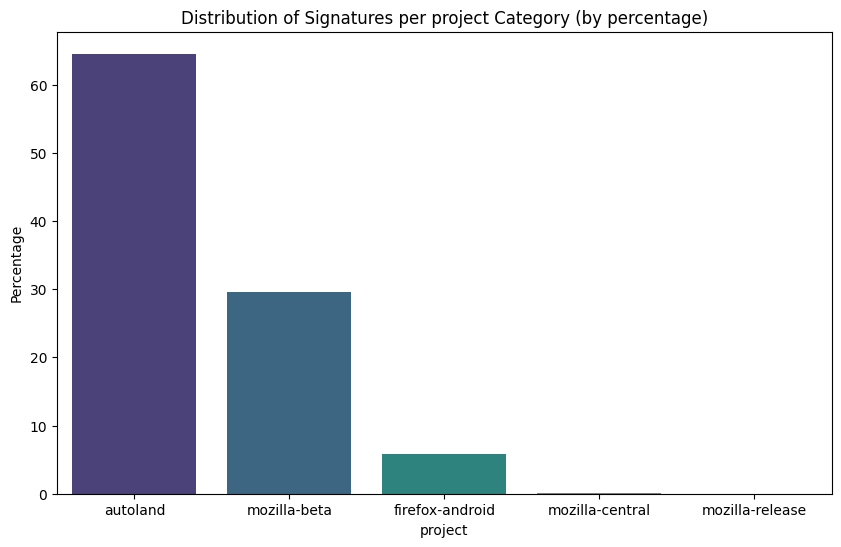

<ipython-input-16-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


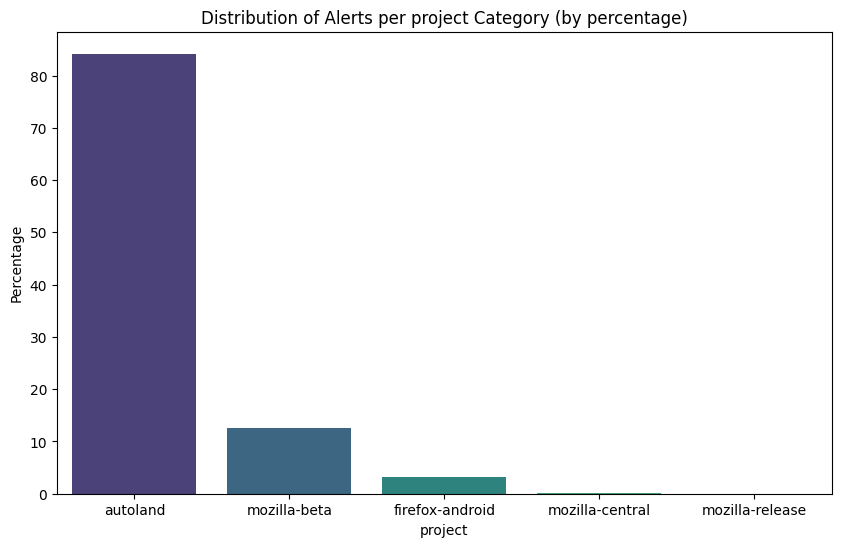

In [17]:
df_sig = df[['alert_repository', 'alert_framework', 'test_series_signature_id']].drop_duplicates()
get_dist_of_cat(df_sig, 'alert_repository', 'project', 'Signatures')
get_dist_of_cat(alerts_df, 'alert_repository', 'project', 'Alerts')

In [18]:
category_percentages = alerts_df['alert_repository'].value_counts(normalize=True) * 100
print(category_percentages)

alert_repository
autoland           84.180929
mozilla-beta       12.591687
firefox-android     3.154034
mozilla-central     0.048900
mozilla-release     0.024450
Name: proportion, dtype: float64


We have been told by the Mozilla team to focus on autoland and mozilla-beta projects since have the existing regression detection running on these projects, which goes hand in hand with what we found in the data as 96.6% of it is coming from these two projects alone. So moving on, we'll focalize the work measurments coming only from these two projects.

In [19]:
alerts_df = alerts_df[alerts_df['alert_repository'].isin(['autoland', 'mozilla-beta'])]
df = df[df['alert_repository'].isin(['autoland', 'mozilla-beta'])]
df_sig = df_sig[df_sig['alert_repository'].isin(['autoland', 'mozilla-beta'])]

In [20]:
def get_dist_by_nb(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf, x=col)
    plt.title(f'Distribution of {cols[col]}')
    plt.ylabel('Count')
    plt.xlabel(f'{cols[col]}')
    plt.xticks(rotation=45)
    plt.show()
def get_dist_by_perc(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=dataf, x=col, y=col, estimator=lambda x: len(x) / len(dataf) * 100)
    plt.title(f'Distribution of {cols[col]} in percentage')
    plt.ylabel('Percentage')
    plt.xlabel(f'{cols[col]}')
    plt.xticks(rotation=45)
    plt.show()

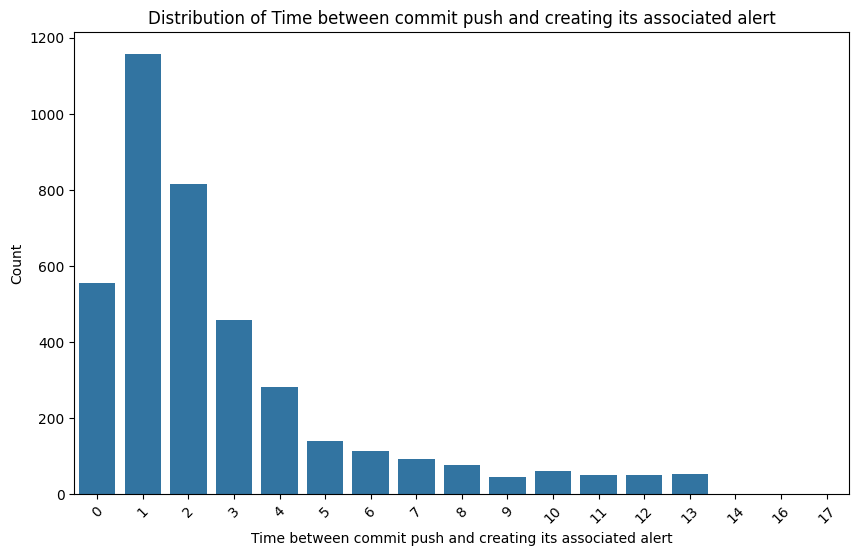

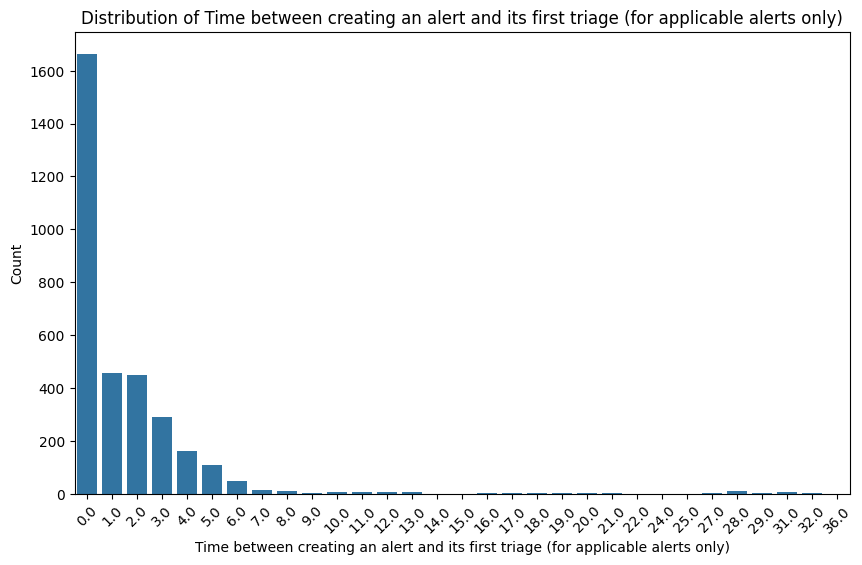

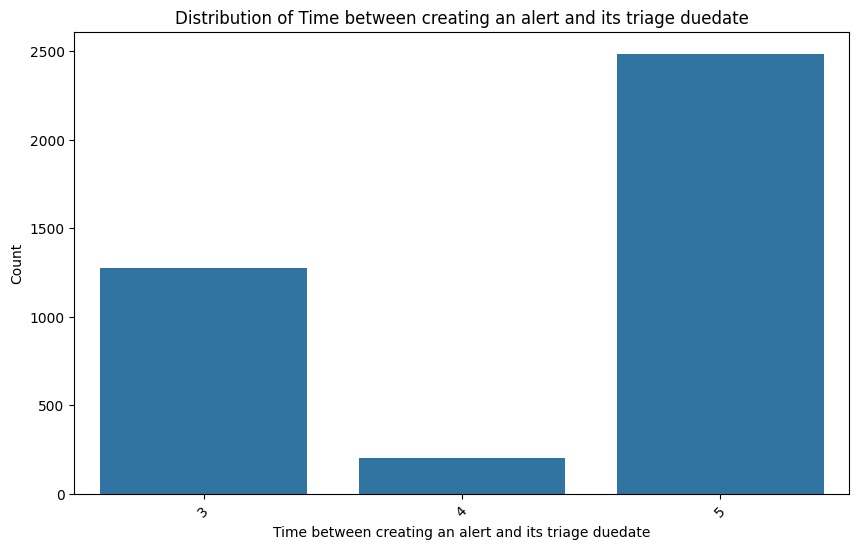

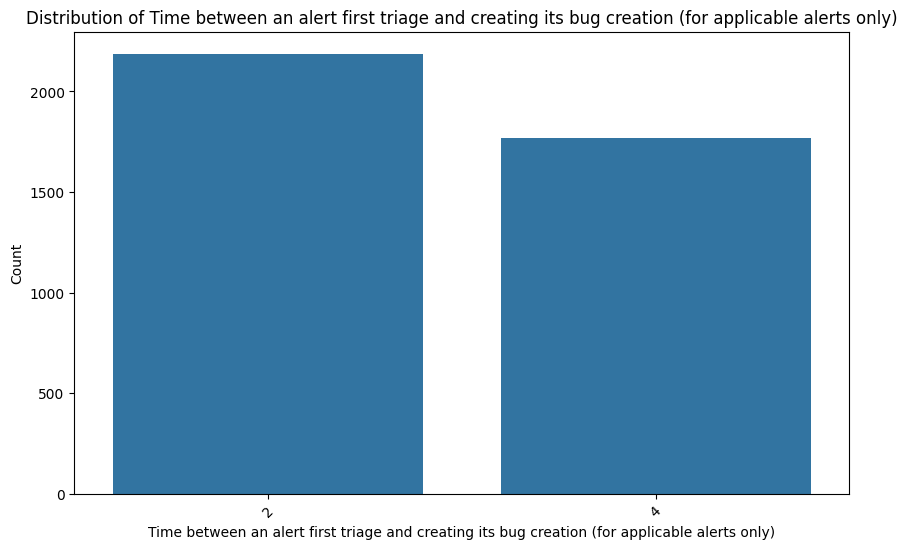

In [21]:
get_dist_by_nb(alerts_df, delta_columns)

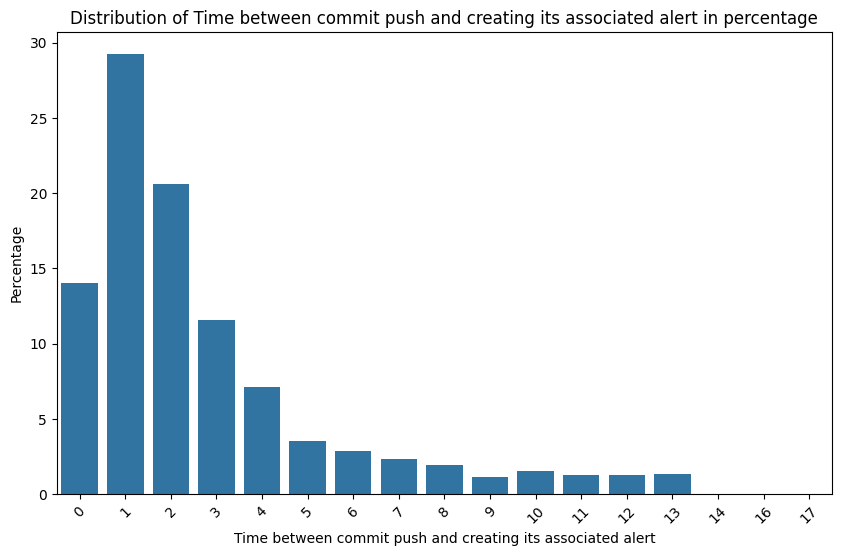

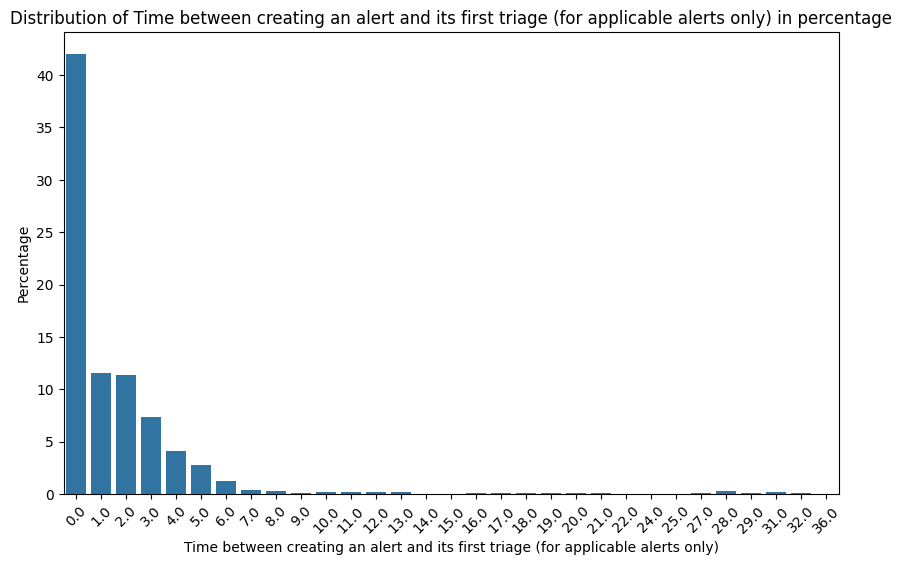

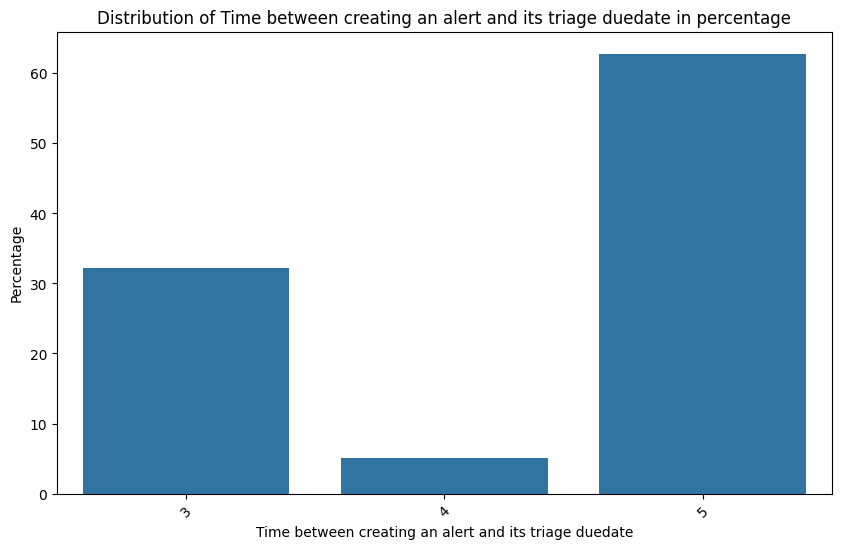

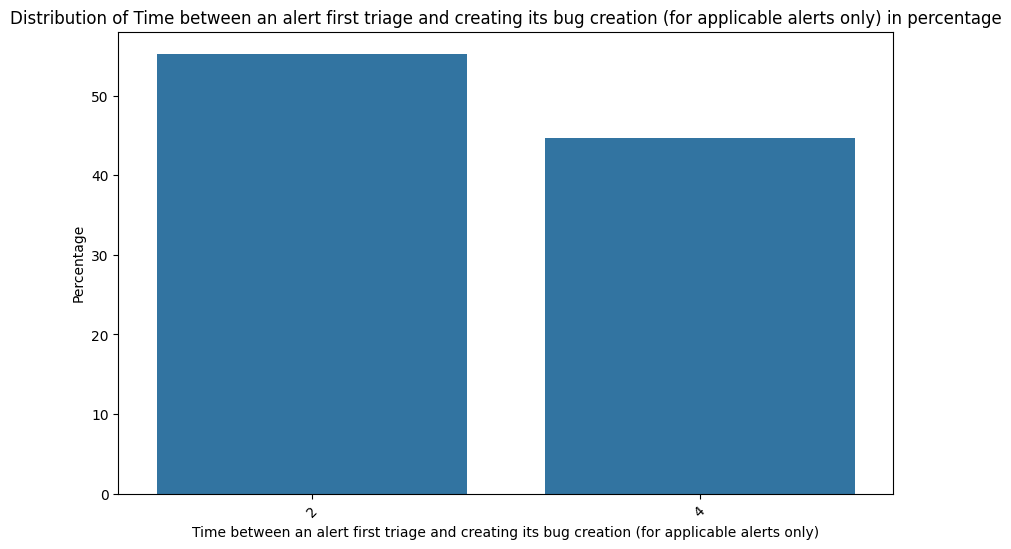

In [22]:
get_dist_by_perc(alerts_df, delta_columns)

The following table presents the median and the mean of the time deltas for each framework

In [23]:
result_mean = alerts_df.groupby('alert_framework')[list(delta_columns.keys())].mean()
result_median = alerts_df.groupby('alert_framework')[list(delta_columns.keys())].median()
result_table = pd.concat([result_mean, result_median], axis=1, keys=['Mean', 'Median']).round(2)
display(result_table)

Mean  \
                    delta_push_to_alert_creation   
alert_framework                                    
awsy                                        2.93   
browsertime                                 3.28   
build_metrics                               1.80   
devtools                                    2.23   
mozperftest                                 2.50   
platform_microbench                         2.02   
talos                                       3.30   

                                                          \
                    delta_alert_creation_to_first_triage   
alert_framework                                            
awsy                                                0.43   
browsertime                                         0.73   
build_metrics                                       0.84   
devtools                                            4.73   
mozperftest                                        16.00   
platform_microbench                                 0.50   
talos                                               0.98   

                                                            \
                    delta_alert_creation_to_triage_duedate   
alert_framework                                              
awsy                                                  4.11   
browsertime                                           4.37   
build_metrics                                         4.25   
devtools                                              4.38   
mozperftest                                           3.75   
platform_microbench                                   4.23   
talos                                                 4.18   

                                                               \
                    delta_alert_first_triaged_to_bug_creation   
alert_framework                                                 
awsy                                                     3.06   
browsertime                                              2.84   
build_metrics                                            2.85   
devtools                                                 2.89   
mozperftest                                              3.50   
platform_microbench                                      2.92   
talos                                                    3.04   

                                          Median  \
                    delta_push_to_alert_creation   
alert_framework                                    
awsy                                         3.0   
browsertime                                  2.0   
build_metrics                                0.0   
devtools                                     2.0   
mozperftest                                  2.5   
platform_microbench                          1.0   
talos                                        2.0   

                                                          \
                    delta_alert_creation_to_first_triage   
alert_framework                                            
awsy                                                 0.0   
browsertime                                          0.0   
build_metrics                                        0.0   
devtools                                             3.0   
mozperftest                                         13.5   
platform_microbench                                  0.5   
talos                                                0.0   

                                                            \
                    delta_alert_creation_to_triage_duedate   
alert_framework                                              
awsy                                                   5.0   
browsertime                                            5.0   
build_metrics                                          5.0   
devtools                                               5.0   
mozperftest                                            3.5   
platform_microbench             

<ipython-input-16-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


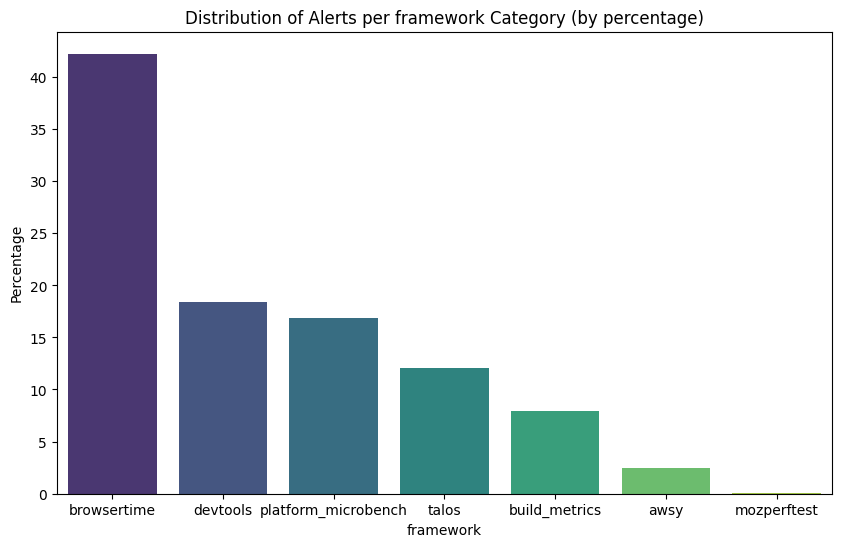

In [24]:
get_dist_of_cat(alerts_df, 'alert_framework', 'framework', 'Alerts')

<ipython-input-16-6e93226eddc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col_counts.index, y=col_counts.values, palette='viridis')


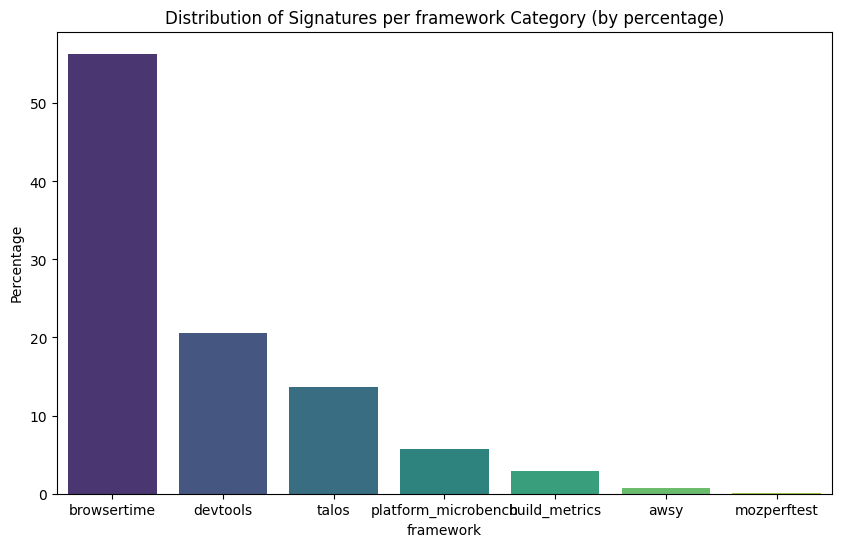

In [25]:
get_dist_of_cat(df_sig, 'alert_framework', 'framework', 'Signatures')

In [26]:
'''timestamp1 = pd.Timestamp('2023-06-19 00:00:00')
timestamp2 = pd.Timestamp('2023-06-25 23:59:59')
print((dist_alerts_df[(dist_alerts_df.index >= timestamp1) & (dist_alerts_df.index <= timestamp2)]).shape)'''

"timestamp1 = pd.Timestamp('2023-06-19 00:00:00')\ntimestamp2 = pd.Timestamp('2023-06-25 23:59:59')\nprint((dist_alerts_df[(dist_alerts_df.index >= timestamp1) & (dist_alerts_df.index <= timestamp2)]).shape)"

On the following weekly classification, a given week spans from Monday at midnight to Sunday 11 PM 59 minutes and 59 seconds

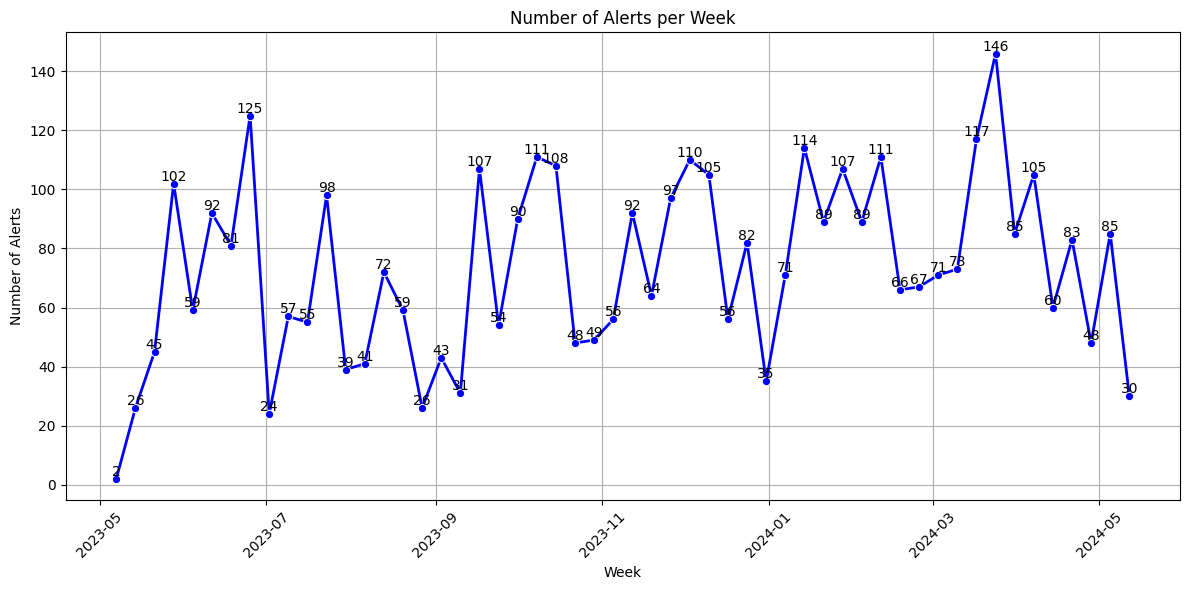

<Figure size 640x480 with 0 Axes>

In [27]:
dist_alerts_df = alerts_df.copy()
dist_alerts_df.set_index('alert_creation_timestamp', inplace=True)

# Resample the data on a weekly basis and count the number of entries per week
weekly_entries = dist_alerts_df.resample('W').size()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=weekly_entries.index, y=weekly_entries.values, marker='o', color='blue', linewidth=2)
plt.title('Number of Alerts per Week')
plt.xlabel('Week')
plt.ylabel('Number of Alerts')
plt.xticks(rotation=45)
plt.grid(True)
for i, value in enumerate(weekly_entries.values):
    plt.text(weekly_entries.index[i], value, str(value), ha='center', va='bottom')
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

The following timeseries graph presents the number of alerts per week for every framework

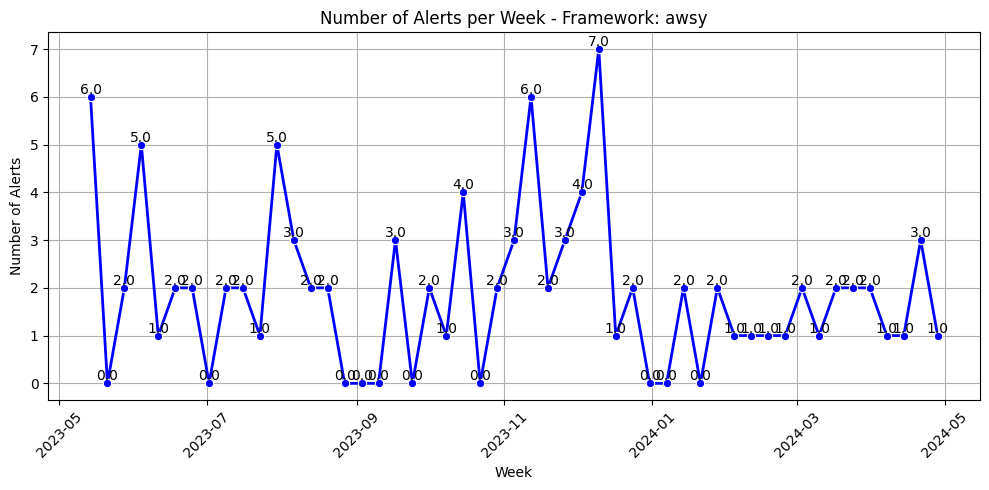

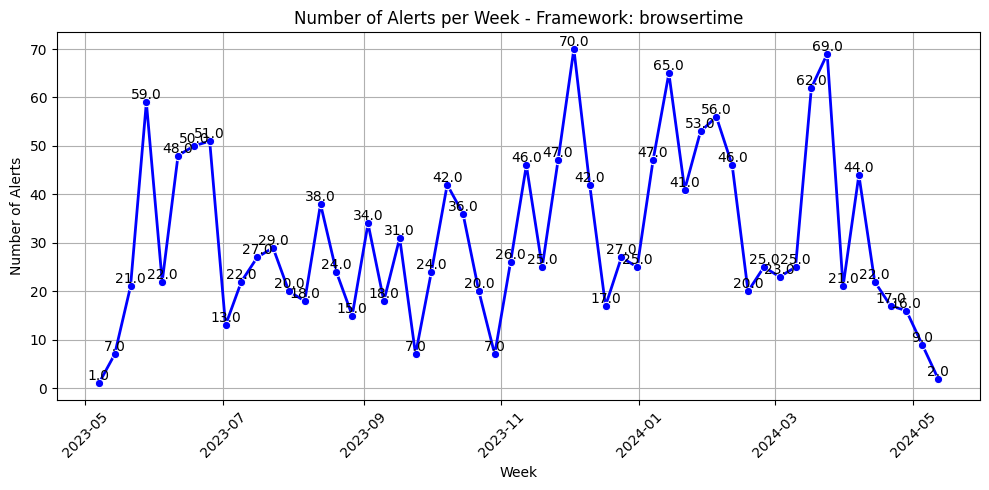

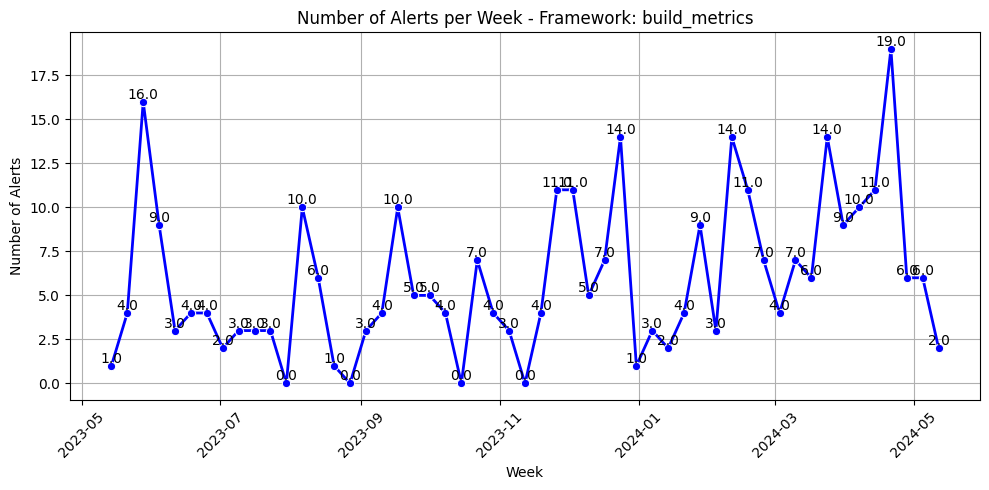

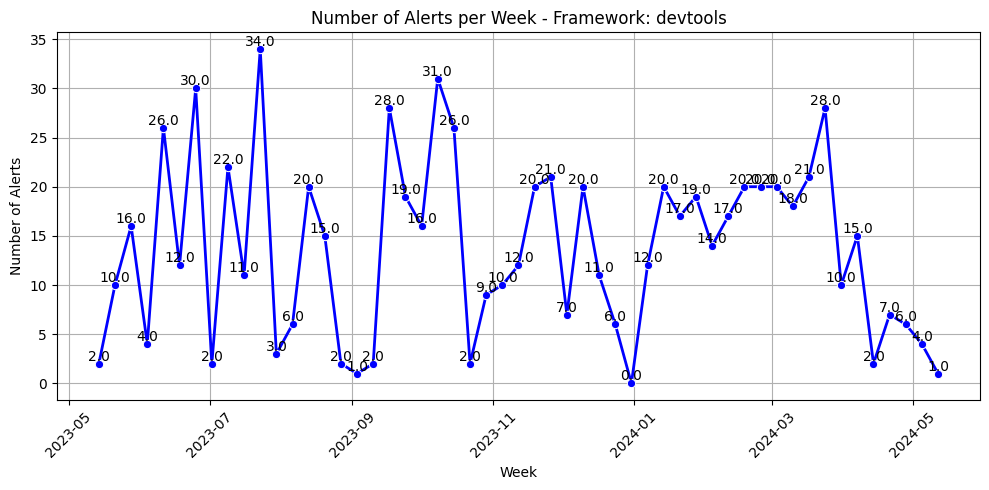

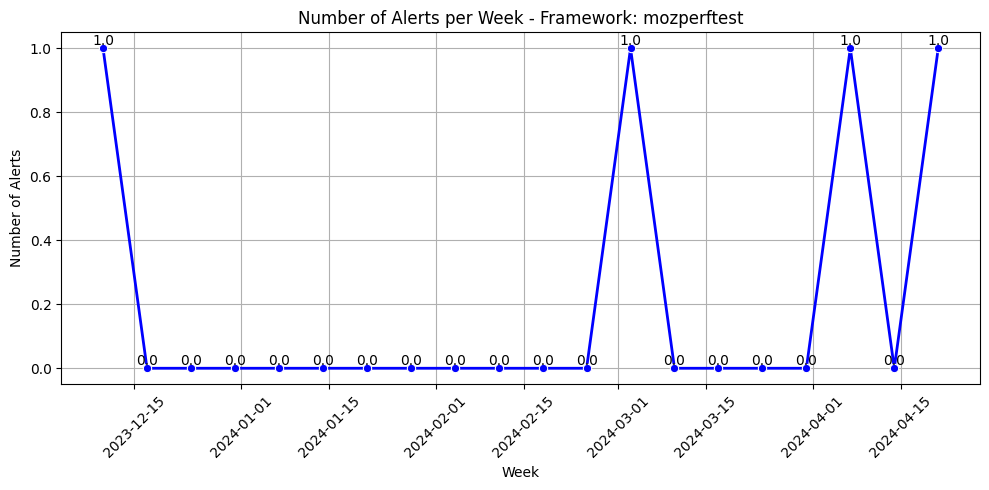

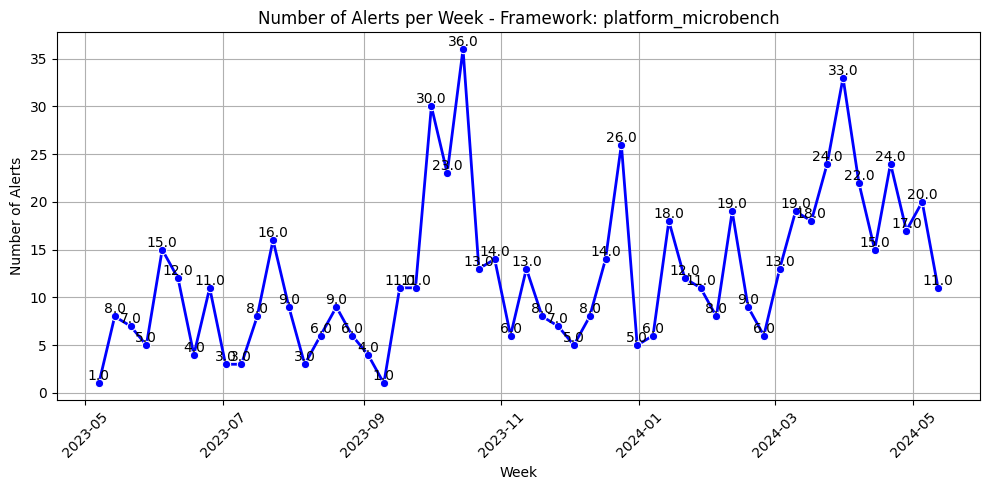

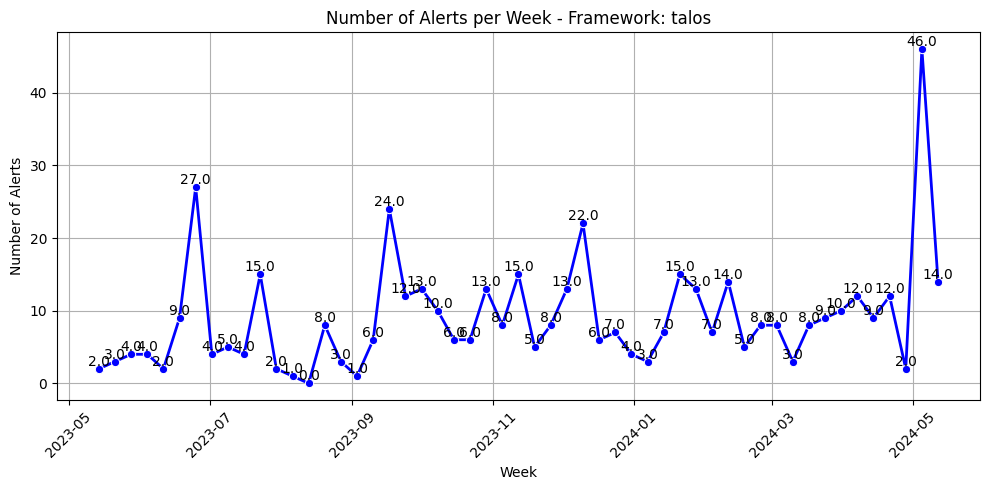

In [28]:
weekly_entries_per_framework = dist_alerts_df.groupby(['alert_framework']).resample('W').size().unstack(level=0)

# Plotting
for framework in weekly_entries_per_framework.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=weekly_entries_per_framework[framework], marker='o', linewidth=2, color='blue')
    # Adding exact number of clients per data point
    for i, value in enumerate(weekly_entries_per_framework[framework]):
        plt.text(weekly_entries_per_framework.index[i], value, str(value), ha='center', va='bottom')
    plt.title(f'Number of Alerts per Week - Framework: {framework}')
    plt.xlabel('Week')
    plt.ylabel('Number of Alerts')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
nan_count = alerts_df['alert_bug_number'].isna().sum()
non_nan_count = alerts_df['alert_bug_number'].notna().sum()

print(f"Number of NaN elements in column '{'alert_bug_number'}': {nan_count}")
print(f"Number of non-NaN elements in column '{'alert_bug_number'}': {non_nan_count}")

Number of NaN elements in column 'alert_bug_number': 3339
Number of non-NaN elements in column 'alert_bug_number': 619


This means that out of 4090 alerts, only 661 alerts (correspondng to 16.1%) have associated bugs.

In [30]:
fp_inv_df = alerts_df.copy()
fp_inv_df = fp_inv_df[~fp_inv_df['alert_status'].isin(["investigating", "untriaged", "downstream"])]

In [31]:
def calculate_category_percentage(dataf, category_column, categories):
    total_rows = len(dataf)
    category_counts = dataf[dataf[category_column].isin(categories)].groupby(category_column).size()
    percentage_dict = {category: (count / total_rows) * 100 for category, count in category_counts.items()}
    return percentage_dict

categories_of_interest = ["improvement", "invalid", "wontfix", "fixed", "backedout", "reassigned"]

# Calculate the percentage for each category
percentage_dict = calculate_category_percentage(fp_inv_df, 'alert_status', categories_of_interest)

#fp = 0
for category, percentage in percentage_dict.items():
    print(f"Percentage of rows with category '{category}': {percentage:.2f}%")
'''
    if category in ["invalid", "wontfix"]:
      fp += percentage
'''
print("Percentage of False Positives: " + str(percentage_dict["invalid"]) + "%")

Percentage of rows with category 'backedout': 0.49%
Percentage of rows with category 'fixed': 3.52%
Percentage of rows with category 'improvement': 26.03%
Percentage of rows with category 'invalid': 19.22%
Percentage of rows with category 'reassigned': 45.48%
Percentage of rows with category 'wontfix': 5.26%
Percentage of False Positives: 19.220582671206962%


In [32]:
df_alerts_bugs = alerts_df[alerts_df['alert_bug_number'].notna()]
print("Number of alerts with related bugs :")
print(df_alerts_bugs.shape[0])
df_alerts_bugs = df_alerts_bugs[df_alerts_bugs['alert_status'].isin(["improvement", "wontfix", "fixed", "backedout", "reassigned"])]
print("Number of true positive alerts with bugs :")
print(df_alerts_bugs.shape[0])
display(df_alerts_bugs.head(5))

Number of alerts with related bugs :
619
Number of true positive alerts with bugs :
355


,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags,delta_push_to_alert_creation,delta_alert_creation_to_first_triage,delta_alert_creation_to_triage_duedate,delta_alert_first_triaged_to_bug_creation
178,74,1417496,1417475,2024-05-03 18:16:39.426431,2024-05-03 18:16:39.818030,2024-05-08 18:16:39.426431,autoland,talos,|231|207|,improvement,1893789.0,2024-05-10 18:16:39.426431,2024-05-08 10:42:01.880978,1,NaN,390e86921c53a6af7280bf83e3b5d485759283e0,2024-04-29 08:18:35,91f7d54aead75a56e132425fa8f764467138d322,mozilla-ldap/bacasandrei@mozilla.com,bacasandrei@mozilla.com,NaN,4,0.0,5,2
436,25,1416664,1416661,2024-04-29 07:35:42.790226,2024-04-29 07:35:43.115101,2024-05-02 07:35:42.790226,autoland,devtools,|33|31|32|34|35|36|,improvement,1890552.0,2024-05-06 07:35:42.790226,2024-04-29 07:38:36.772737,1,NaN,4ae03cc6083fd67592b64b259a4bfad4e7d3ace9,2024-04-26 09:21:41,f10daac4c929c07fb9eb03cafd28130854277869,NaN,NaN,NaN,2,0.0,3,4
450,16,1410269,1410263,2024-04-26 13:31:27.734956,2024-04-26 13:31:27.905310,2024-05-01 13:31:27.734956,autoland,talos,|193432|193436|193437|193431|193544|193532|,improvement,1888748.0,2024-05-03 13:31:27.734956,2024-04-26 14:02:22.120184,1,NaN,d06a0d7b341361ec7d0e996636f94a7ebd68b92e,2024-04-17 06:10:00,54882b6de6ac255482abf21e352f2337a1317d3f,mozilla-ldap/aglavic@mozilla.com,aglavic@mozilla.com,improvement,9,0.0,5,2
451,15,1409812,1409803,2024-04-26 13:29:00.569284,2024-04-26 13:29:00.709729,2024-05-01 13:29:00.569284,autoland,talos,|193403|193422|193394|,improvement,1888628.0,2024-05-03 13:29:00.569284,2024-04-26 14:15:03.853915,1,NaN,3b76cb83627af4607b79caf70a03243e6ee6369b,2024-04-16 16:29:24,6c6258954d92b34174ed0fb95bb92107a5c602ad,mozilla-ldap/aglavic@mozilla.com,aglavic@mozilla.com,improvement,9,0.0,5,2
458,8,1413921,1413770,2024-04-25 15:21:43.752708,2024-04-29 07:31:14.185105,2024-04-30 15:21:43.752708,autoland,devtools,NaN,improvement,1888607.0,2024-05-02 15:21:43.752708,2024-04-29 07:31:14.185205,1,NaN,d0b5d121d8fc8ffddbec3e026a455ecfe0071347,2024-04-23 11:54:58,5519716422b3e14060894caded45bac7a3aeb773,NaN,NaN,NaN,2,3.0,5,2


The following presents the number of alerts that have associated test suite "Speedometer3"

In [33]:
speedometer_alerts = df[["alert_id", "test_series_signature_suite"]].drop_duplicates()
category_to_find = 'speedometer3'
total_rows = len(alerts_df)
rows_with_category = len(speedometer_alerts[speedometer_alerts['test_series_signature_suite'] == category_to_find])
percentage = (rows_with_category / total_rows) * 100
print(f"Percentage of alerts associated with Speedometer3 test suite : {percentage:.2f}%")

Percentage of alerts associated with Speedometer3 test suite : 1.59%


In [34]:
category_to_find = 'tp6'
tp6_rows_count = df[df['test_series_signature_extra_options'].str.contains(category_to_find, na=False)]['alert_id'].nunique()
percentage = (tp6_rows_count / total_rows) * 100
print(f"Percentage of alerts associated with TP6 test suite : {percentage:.2f}%")

Percentage of alerts associated with TP6 test suite : 0.81%
